In [42]:
%matplotlib inline
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [12]:
data = pd.read_csv('train.csv')
data['comments'] = data['comments'].fillna('')
train, test = train_test_split(data, train_size=.2)

In [17]:
 def test_model(model, ngrams):
    pipeline = Pipeline([
            ('vectorizer', CountVectorizer(ngram_range=ngrams)),
            ('model', model)
    ])

    cv = GridSearchCV(pipeline, {}, scoring='mean_squared_error', n_jobs=-1)
    cv = cv.fit(train['comments'], train['quality'])
    validation_score = cv.best_score_
    predictions = cv.predict(test['comments'])
    test_score = mean_squared_error(test['quality'], predictions)
    return validation_score, test_score

In [26]:
import itertools

models = [('ols', LinearRegression()), ('ridge', Ridge()), ('lasso', Lasso())]
ngram_ranges = [(1, 1), (1, 2), (1, 3)]

scores = []
for m, ngram in itertools.product(models, ngram_ranges):
    name = m[0]
    model = m[1]
    validation_score, test_score = test_model(model, ngram)
    scores.append({'score': -validation_score, 'model': name, 'ngram': str(ngram), 'fold': 'validation'})
    scores.append({'score': test_score, 'model': name, 'ngram': str(ngram), 'fold': 'test'})

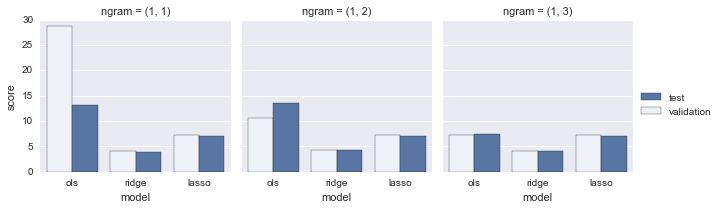

In [69]:
import seaborn as sb
import matplotlib.pyplot as plt

df = pd.DataFrame(scores)
g = sb.FacetGrid(df, col='ngram', palette='Paired')
g.map_dataframe(sb.barplot, 'model', 'score', hue='fold').add_legend()
g.savefig('linear-models.png', format='png', dpi=300)

In [95]:
df

,fold,model,ngram,score
0,validation,ols,"(1, 1)",28.744166
1,test,ols,"(1, 1)",13.084306
2,validation,ols,"(1, 2)",10.633101
3,test,ols,"(1, 2)",13.537418
4,validation,ols,"(1, 3)",7.173745
5,test,ols,"(1, 3)",7.494989
6,validation,ridge,"(1, 1)",4.175966
7,test,ridge,"(1, 1)",3.956131
8,validation,ridge,"(1, 2)",4.318178
9,test,ridge,"(1, 2)",4.281055


In [86]:
from sklearn.tree import DecisionTreeRegressor
tree_scores = []
for i in [10, 25, 50, 75, 100]:
    validation_score, test_score = test_model(DecisionTreeRegressor(max_depth=i), (1, 1))
    tree_scores.append({'Max Depth': i, 'score': -validation_score, 'fold': 'validation'})
    tree_scores.append({'Max Depth': i, 'score': test_score, 'fold': 'test'})

In [87]:
tree_df = pd.DataFrame(tree_scores)
tree_df

,Max Depth,fold,score
0,10,validation,5.098938
1,10,test,5.004342
2,25,validation,5.474429
3,25,test,5.172275
4,50,validation,6.421006
5,50,test,6.025583
6,75,validation,6.720701
7,75,test,6.531834
8,100,validation,6.843992
9,100,test,6.594446


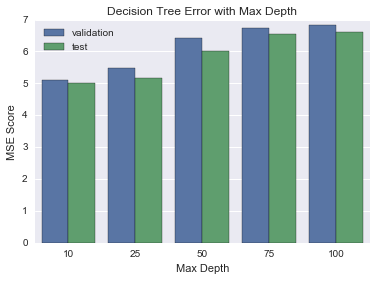

In [91]:
g = sb.barplot(x='Max Depth', y='score', hue='fold', data=tree_df, ci=None)
plt.legend(loc='upper left')
plt.ylabel('MSE Score')
plt.title('Decision Tree Error with Max Depth')
plt.savefig('plot-tree-overfitting.png', format='png', dpi=300)

In [90]:
from sklearn.ensemble import RandomForestRegressor

rf_scores = []
for i in [10, 25, 50, 75, 100]:
    validation_score, test_score = test_model(
        RandomForestRegressor(max_depth=i, n_jobs=-1),
        (1, 1)
    )
    rf_scores.append({'Max Depth': i, 'score': -validation_score, 'fold': 'validation'})
    rf_scores.append({'Max Depth': i, 'score': test_score, 'fold': 'test'})

In [92]:
rf_df = pd.DataFrame(rf_scores)
rf_df

,Max Depth,fold,score
0,10,validation,4.838360
1,10,test,4.814044
2,25,validation,4.208798
3,25,test,4.104081
4,50,validation,4.065015
5,50,test,3.965905
6,75,validation,4.068770
7,75,test,3.947820
8,100,validation,4.051910
9,100,test,3.973747


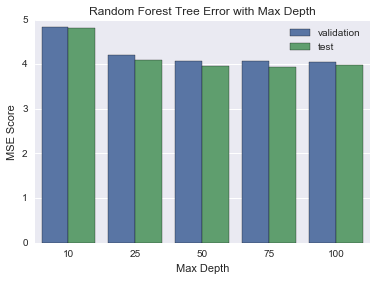

In [94]:
g = sb.barplot(x='Max Depth', y='score', hue='fold', data=rf_df, ci=None)
plt.legend(loc='upper right')
plt.ylabel('MSE Score')
plt.title('Random Forest Tree Error with Max Depth')
plt.savefig('plot-rf-overfitting.png', format='png', dpi=300)

In [96]:
test_model(
        RandomForestRegressor(n_jobs=-1),
        (1, 1)
    )

(-4.0844345776560385, 3.9767695185989131)